In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

## Calculating the X-ray Spectrum

In [2]:
# Loading response matrices
rmf = fits.open("data/pspcb_gain2_256.rmf")
arf = fits.open("data/pspcb_gain2_256.arf")

# Setting for X-ray parameters
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

Zmetal = 0.3
Zs = np.ones(31)
Zs[3:] = Zmetal

# Initialize ROSAT spectrum session
rosat_spectrum = pyatomdb.spectrum.CIESession()
rosat_spectrum.set_response(rmf, arf)
rosat_spectrum.set_abund(np.arange(31, dtype=int), Zs)

# Load or calculate integrated X-ray spectra
if os.path.isfile("data/Jtot.pck"):
    with open("data/Jtot.pck", "rb") as f:
        J_tot = pickle.load(f)
else:
    J_tot = rosat_spectrum.return_integrated_spectrum_interp(
        kTmin, kTmax, nkT, zmax, nz, emin, emax)

# Load or calculate continuum-only X-ray spectra
if os.path.isfile("data/Jcont.pck"):
    with open("data/Jcont.pck", "rb") as f:
        J_cont = pickle.load(f)
else:
    J_cont = rosat_spectrum.return_integrated_spectrum_interp(
        kTmin, kTmax, nkT, zmax, nz, emin, emax, dolines=False, dopseudo=False)

## Set up profiles

In [3]:
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)
dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)

density_profile = rx.HaloProfileDensityHE(mass_def=mdef,
                                          kind="n_total",
                                          concentration=cM)
pressure_profile = rx.HaloProfilePressureHE(mass_def=mdef,
                                            kind="n_total",
                                            concentration=cM)
xtot = rx.HaloProfileXray(mass_def=mdef,
                          J=J_tot,
                          density=density_profile,
                          pressure=pressure_profile,
                          fourier_approx=False,
                          with_clumping=True)

xcont = rx.HaloProfileXray(mass_def=mdef,
                           J=J_cont,
                           density=density_profile,
                           pressure=pressure_profile,
                           fourier_approx=False,
                           with_clumping=True)

Precompute parameters of Fourier-space profiles (pretty slow)

In [4]:
with ccl.UnlockInstance(xcont):
    xcont._get_fourier_params(cosmo)
with ccl.UnlockInstance(xtot):
    xtot._get_fourier_params(cosmo)

/Users/ferreirat/Desktop/Xrays/main/xCell-likelihoods/papers/ROSATx/rosatX/profiles.py:1050: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fhi = np.array([quad(
/Users/ferreirat/Desktop/Xrays/main/xCell-likelihoods/papers/ROSATx/rosatX/profiles.py:1057: RuntimeWarning: invalid value encountered in power
  q_pivot = qhi / (f0 / fhi - 1) ** (1 / slope_hik)
/Users/ferreirat/Desktop/Xrays/main/xCell-likelihoods/papers/ROSATx/rosatX/profiles.py:1058: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The err

Plot real and Fourier-space profiles

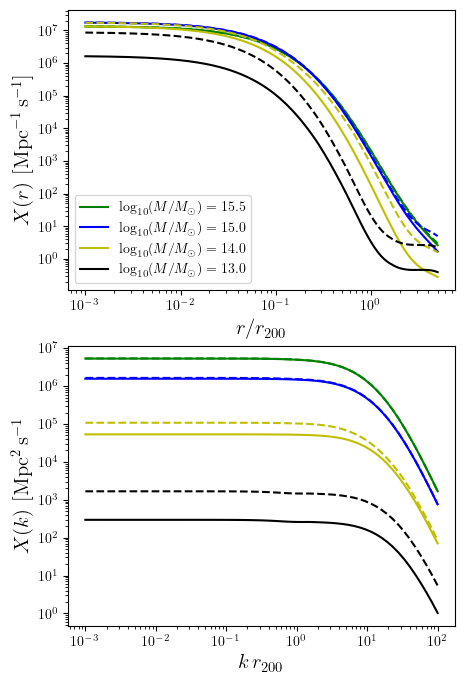

<Figure size 640x480 with 0 Axes>

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
ax1, ax2 = axs
plt.figure()
a = 1.0
x_out = 5
for c, lM in zip(["g", "b", "y", "k"], [15.5, 15, 14, 13]):
    M = 10.0**lM
    r200 = mdef.get_radius(cosmo, M, a) / a
    x = np.geomspace(1e-3, x_out, 256)
    q = np.geomspace(1e-3, 100, 64)
    # Real
    fx = xcont.real(cosmo, r200 * x, M, a)
    ax1.plot(x, fx, c + "-", label=r"$\log_{10}(M/M_\odot)=%.1lf$" % lM)
    fx = xtot.real(cosmo, r200 * x, M, a)
    ax1.plot(x, fx, c + "--")
    # Fourier
    fq = xcont.fourier(cosmo, q / r200, M, a)
    ax2.plot(q, fq, c + "-")
    fq = xtot.fourier(cosmo, q / r200, M, a)
    ax2.plot(q, fq, c + "--")
for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
ax1.legend();

ax1.set_ylabel(r"$X(r)\,\,[{\rm Mpc}^{-1}\,{\rm s}^{-1}]$", fontsize=15);
ax2.set_ylabel(r"$X(k)\,\,[{\rm Mpc}^2\,{\rm s}^{-1}$", fontsize=15);
ax1.set_xlabel(r"$r/r_{200}$", fontsize=15);
ax2.set_xlabel(r"$k\,r_{200}$", fontsize=15);

## Generate radial tracers

We generate galaxy clustering and shear tracers for some imaginary sample at $z\sim0.5$ with $\sigma_z\sim0.05$

In [6]:
zs = np.linspace(0.0, 1.0, 512)
nz = np.exp(-0.5 * ((zs - 0.5) / 0.05) ** 2)

# X-ray tracer
tx = rx.XrayTracer(cosmo)

# delta_g tracer
tg = ccl.NumberCountsTracer(cosmo, dndz=(zs, nz), bias=(zs, np.ones_like(nz)),has_rsd=False)

# gamma tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

## Inspecting the halo profiles

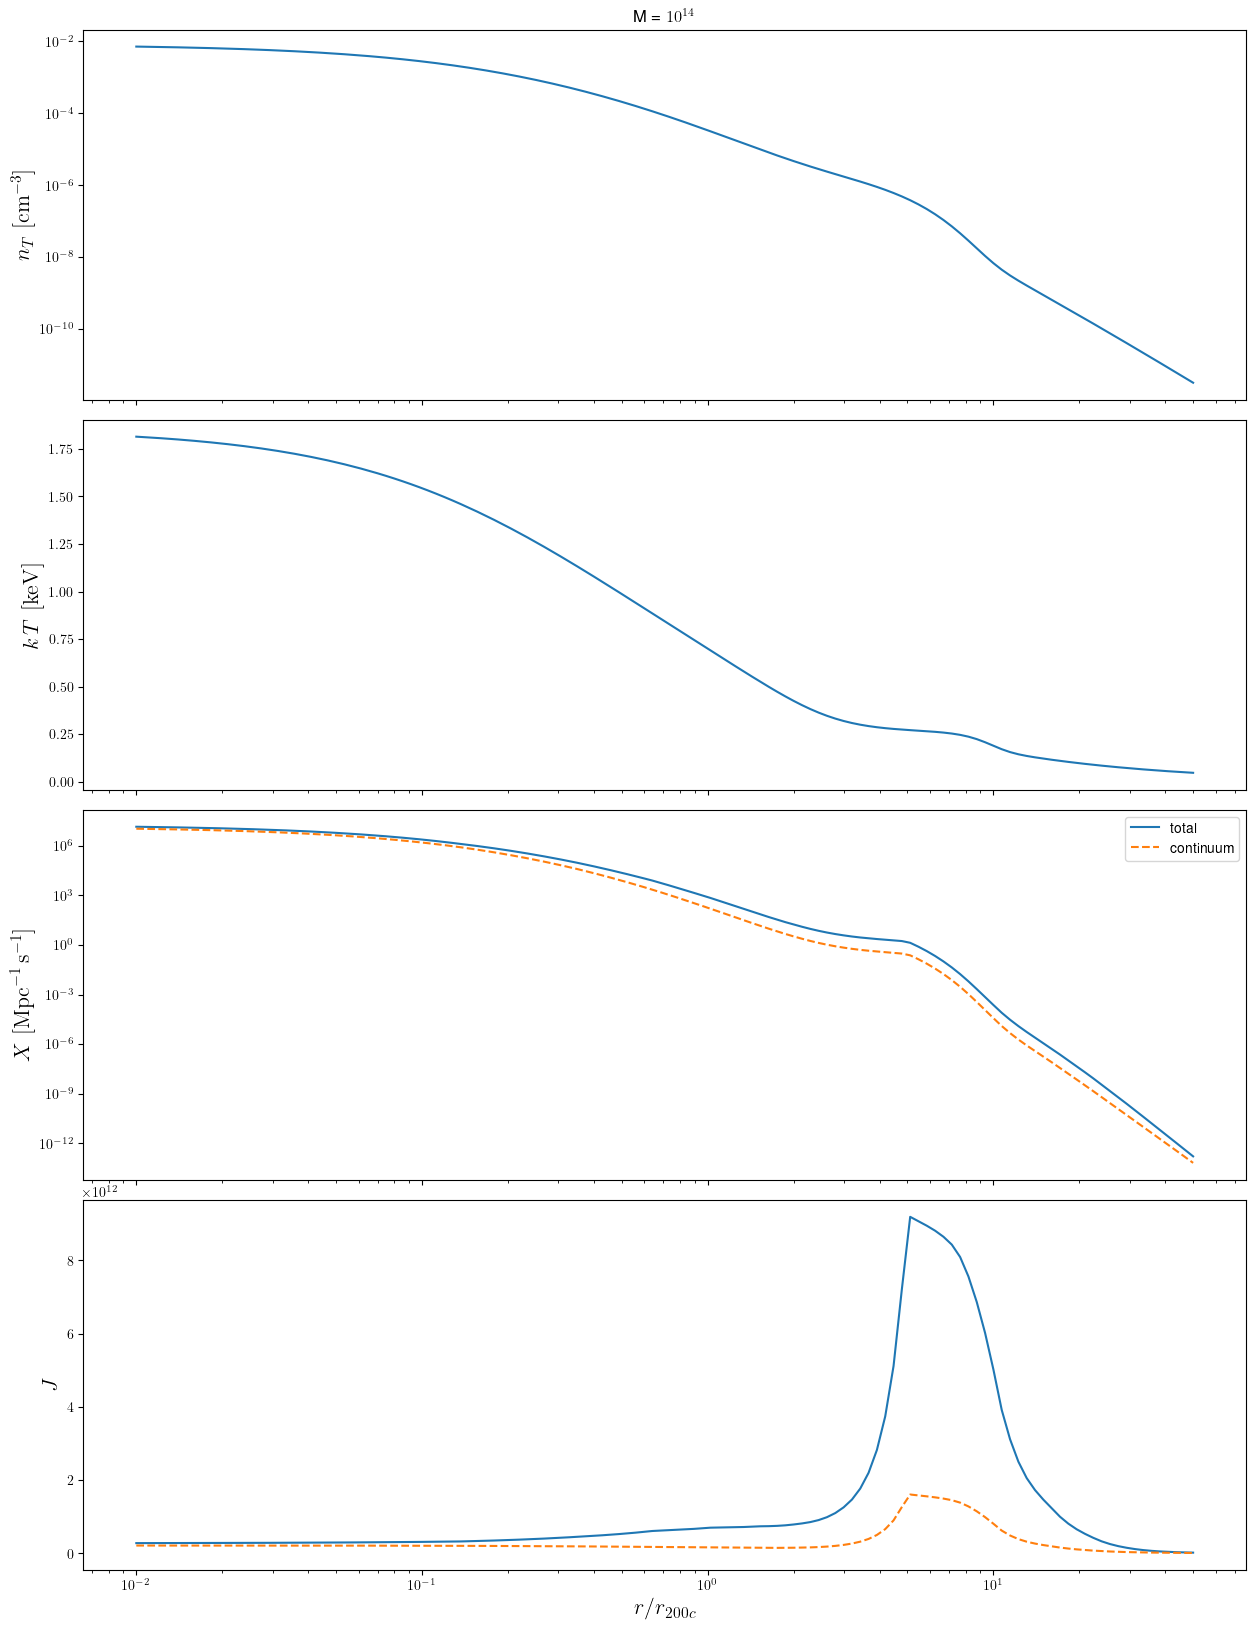

In [7]:
M = 1e14
a = 1.
r200 = mdef.get_radius(cosmo, M, a) / a
x = np.geomspace(0.01, 50, 128)
r = r200 * x
p_density = density_profile.real(cosmo, r, M, a)
p_pressure = pressure_profile.real(cosmo, r, M, a)
p_dmat = dmat.real(cosmo, r, M, a)
p_xtot = xtot.real(cosmo, r, M, a)
p_xcont = xcont.real(cosmo, r, M, a)

fig, ax = plt.subplots(4, 1, figsize=(15, 20))
    
ax[0].plot(x, p_density)
ax[0].tick_params(labelbottom=False)

ax[1].plot(x, 1e-3*p_pressure/p_density)
ax[1].tick_params(labelbottom=False)

ax[2].plot(x, p_xtot, label='total')
ax[2].plot(x, p_xcont, linestyle="--", label='continuum')
ax[2].tick_params(labelbottom=False)
ax[2].legend()

ax[3].plot(x, p_xtot/p_density**2)
ax[3].plot(x, p_xcont/p_density**2, linestyle="--")

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xscale('log')
    
ax[0].set_ylabel(r'$n_T\,\,[{\rm cm}^{-3}]$', fontsize=16)
ax[1].set_ylabel(r'$k\,T\,\,[{\rm keV}]$', fontsize=16)
ax[2].set_ylabel(r'$X\,\,[{\rm Mpc}^{-1}\,{\rm s}^{-1}]$', fontsize=16)
ax[3].set_ylabel(r'$J$', fontsize=16)

ax[3].set_xlabel(r'$r/r_{200c}$', fontsize=16)

ax[0].set_title('M = $10^{14}$');
plt.subplots_adjust(hspace=0.055)

fig.savefig('Plots/HE_Profiles.pdf')

## Compute halo model power spectra

In [8]:
nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_def=mdef,
                             mass_function=nM,
                             halo_bias=bM,
                             log10M_max=15.0,
                             log10M_min=10,
                             nM=32)

In [9]:
k_arr = np.geomspace(1e-4, 1e2, 256)
a_arr = np.linspace(0.3, 1, 8)

pk_MMf = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                               lk_arr=np.log(k_arr),
                               a_arr=a_arr)

In [10]:
pk_Mxf_tot = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                    prof2=xtot,
                                    lk_arr=np.log(k_arr),
                                    a_arr=a_arr)
pk_Mxf_cont = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                     prof2=xcont,
                                     lk_arr=np.log(k_arr),
                                     a_arr=a_arr)

In [11]:
pk_xxf_tot = ccl.halos.halomod_Pk2D(cosmo, hmc, xtot,
                                    prof2=xtot,
                                    lk_arr=np.log(k_arr),
                                    a_arr=a_arr)
pk_xxf_cont = ccl.halos.halomod_Pk2D(cosmo, hmc, xcont,
                                     prof2=xcont,
                                     lk_arr=np.log(k_arr),
                                     a_arr=a_arr)

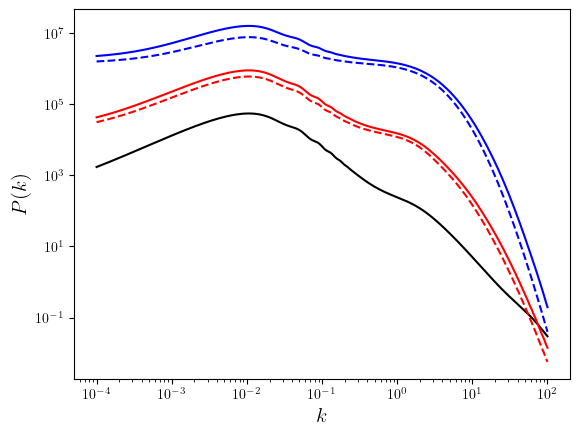

In [12]:
a = 1 / (1 + 0.5)
plt.plot(k_arr, pk_MMf(k_arr, a, cosmo), 'k-')
plt.plot(k_arr, pk_Mxf_tot(k_arr, a, cosmo), 'r-')
plt.plot(k_arr, pk_Mxf_cont(k_arr, a, cosmo), 'r--')
plt.plot(k_arr, pk_xxf_tot(k_arr, a, cosmo), 'b-')
plt.plot(k_arr, pk_xxf_cont(k_arr, a, cosmo), 'b--')
plt.loglog()
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15);

## Compute angular power spectra

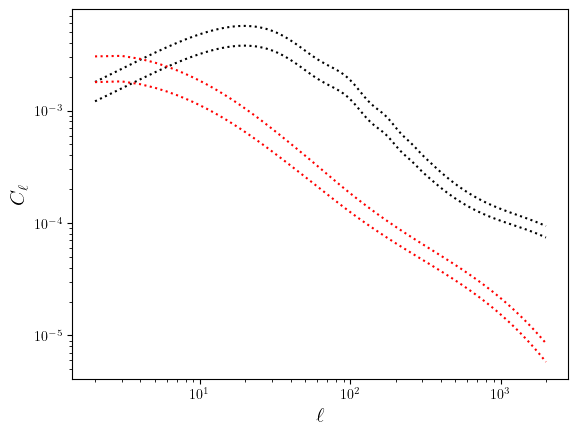

In [13]:
ls = np.unique(np.geomspace(2, 2000, 128).astype(int)).astype(float)
cl_gx1 = ccl.angular_cl(cosmo, tg, tx, ls, p_of_k_a=pk_Mxf_tot)
cl_gx2 = ccl.angular_cl(cosmo, tg, tx, ls, p_of_k_a=pk_Mxf_cont)
cl_sx1 = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_Mxf_tot)
cl_sx2 = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_Mxf_cont)

plt.plot(ls, cl_gx1, 'k:')
plt.plot(ls, cl_gx2, 'k:')
plt.plot(ls, cl_sx1, 'r:')
plt.plot(ls, cl_sx2, 'r:')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15);